# Imports

In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from scipy.stats import shapiro, pointbiserialr
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from category_encoders.sum_coding import SumEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder

In [2]:
data = pd.read_csv('weatherAUS.csv')

In [3]:
data

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

In [4]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

# Convert Columns

In [6]:
cont_var = data.select_dtypes('float64').columns.to_list()

In [7]:
data.Date = pd.to_datetime(data.Date)
data.RainToday = data.RainToday.replace({'No':0, 'Yes':1})
data.RainTomorrow = data.RainTomorrow.replace({'No':0, 'Yes':1})

In [286]:
data.shape

(145460, 23)

# Check NAs

In [287]:
data.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

## Drop NAs

In [10]:
data.dropna(how='all', inplace=True) #Drop lines with all columns NA
data.dropna(subset=['RainTomorrow'], inplace=True)
data.dropna(inplace=True) #droppping all NAs for the exploration only

In [11]:
target = 'RainTomorrow'

# Date

**Adding month, season, wet season**
<p>Rain is more frequentrly in certain times of the year <br>
<a href=https://www.australia.com/en/facts-and-planning/when-to-go/australias-seasons.html>Australia's Seasons</>

In [290]:
data['month'] = data.Date.dt.month
data['season'] = data.apply(lambda x : x.month%12 // 3 + 1, axis=1)
data['wet_season'] = data.apply(lambda row : row.month in (11, 12, 1, 2, 3, 4), axis=1).astype('int32')

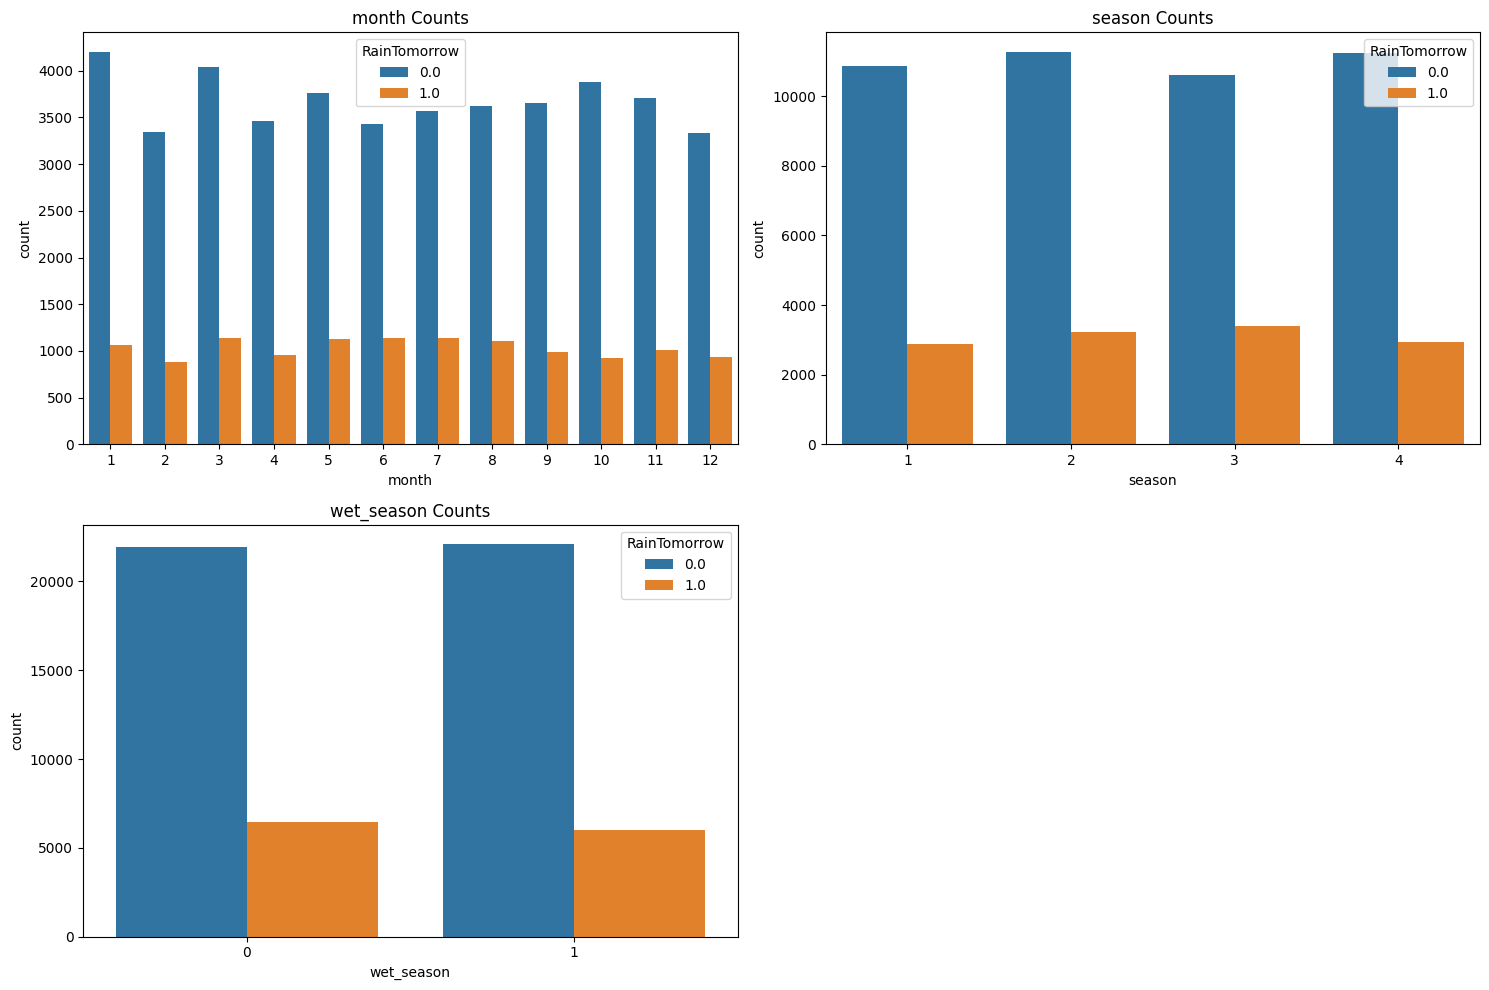

In [291]:
date_cols = ['month', 'season', 'wet_season']

figure, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
ax = ax.flatten()

for i, column in enumerate(date_cols):

    sns.countplot(data=data, x=data[column], hue=data.RainTomorrow, ax=ax[i])

    ax[i].set_title(column + ' Counts')
ax[3].axis('off')
plt.tight_layout()

<p>Rain seems to ve more frequent in certain seasons, but the diference is negligible.
<p>Wet season doesn't have any relation with target.

# Continuous Variables

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10500\2378394198.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


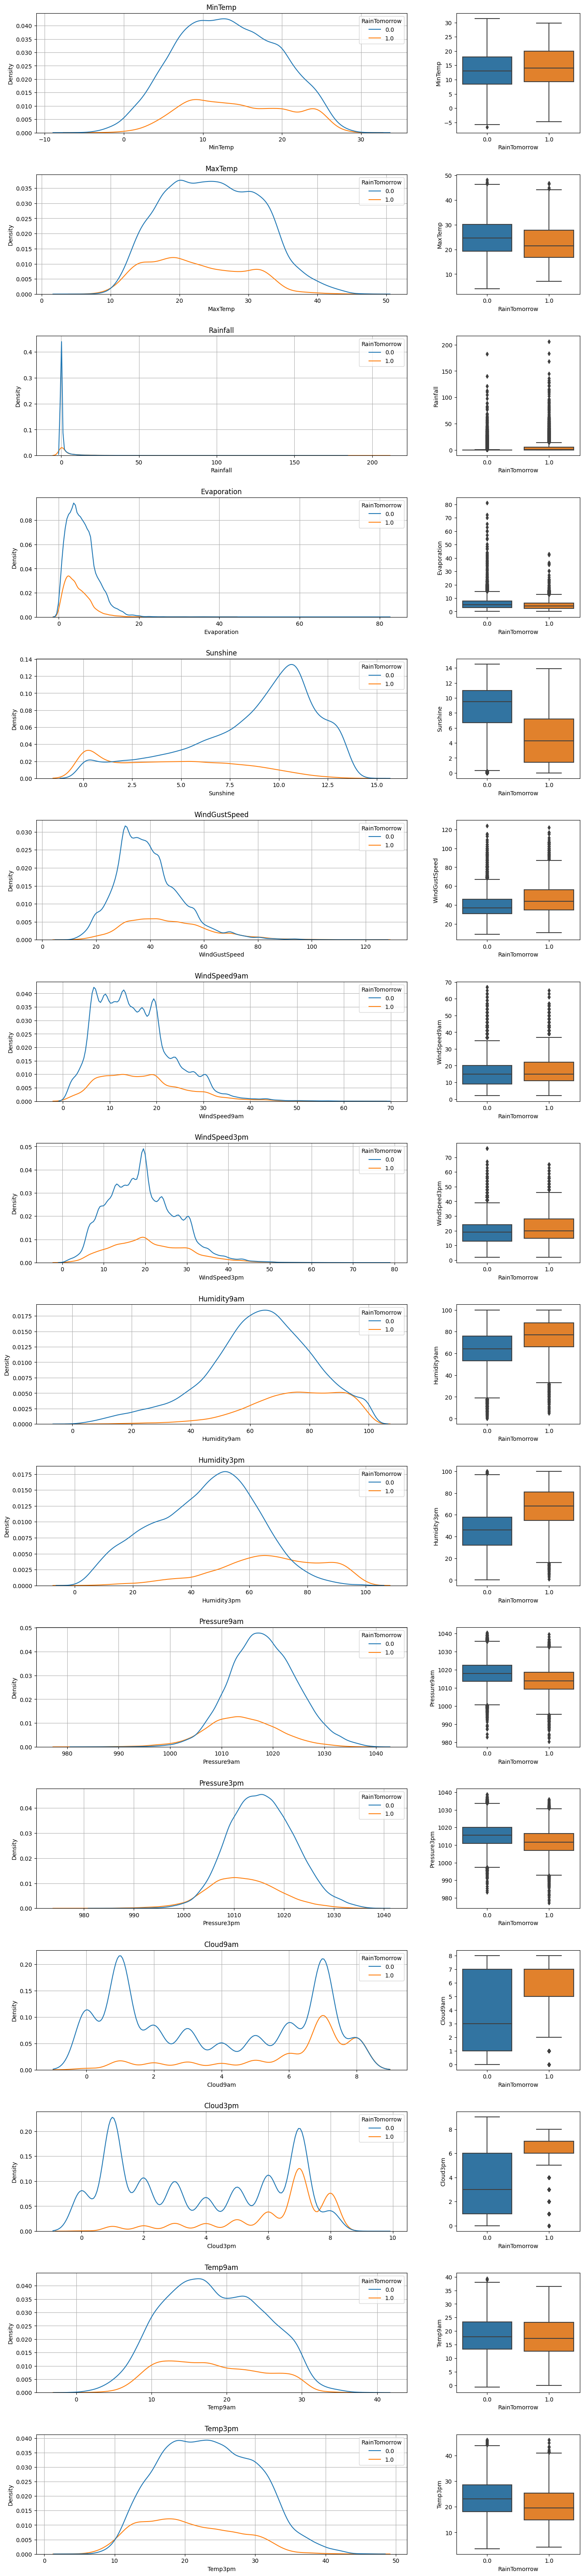

In [292]:
fig, axs = plt.subplots(nrows=len(cont_var), ncols=2, figsize=(17, len(cont_var) * 5),
                        gridspec_kw = {'hspace': 0.35, 'wspace': 0.2, 'width_ratios': [0.75, 0.25]})

for i, col in enumerate(cont_var):
    ax = axs[i, 0]
    sns.kdeplot(data=data[[col, 'RainTomorrow']], x=col, hue='RainTomorrow', ax=ax)
    ax.set_title(col)
    ax.grid(visible=True)

    ax = axs[i, 1]
    sns.boxplot(data=data[[col, target]], x=target, y=col, ax=ax)

plt.tight_layout()

<Axes: >

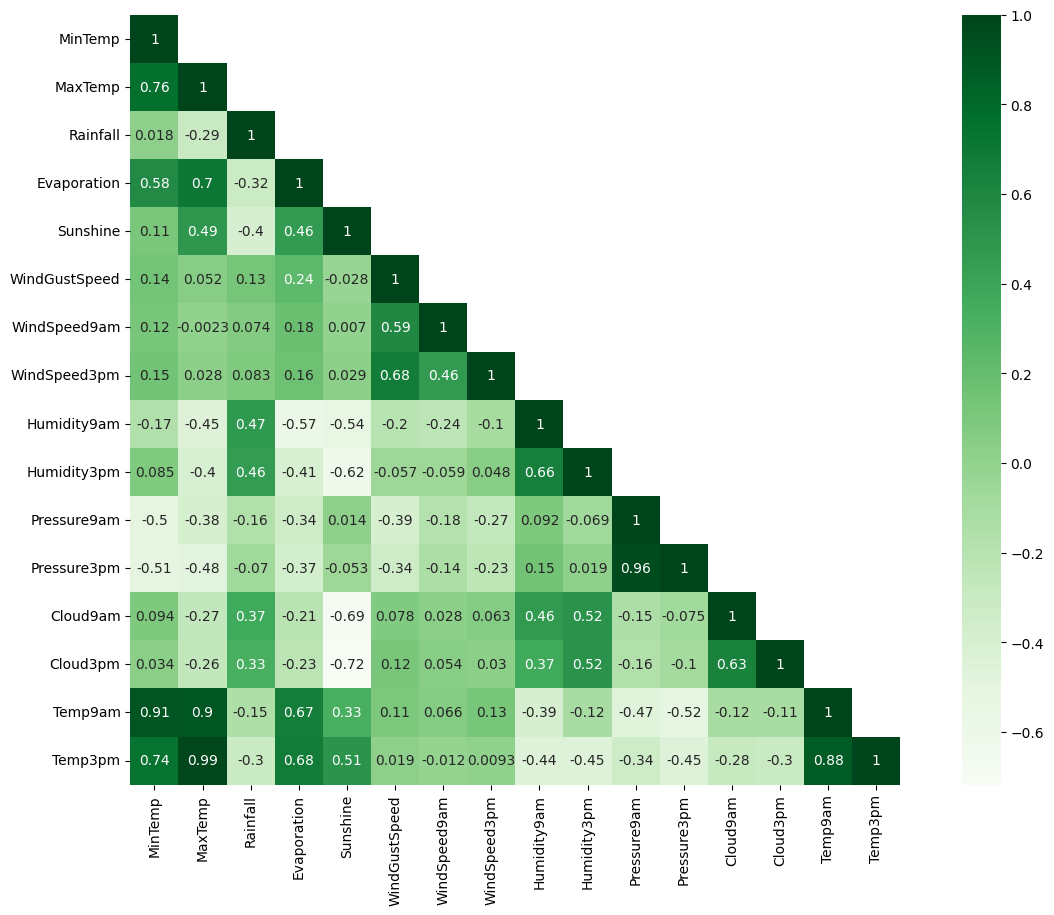

In [294]:
corr_matrix = data[cont_var].corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
np.fill_diagonal(mask, False)

fig = plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap='Greens', square=True, annot=True, mask=mask)

In [295]:
corr_df = []
for col in cont_var:
    corr_df.append(pointbiserialr(data.RainTomorrow, data[col]).correlation)

pd.DataFrame(zip(cont_var, corr_df), columns=['Col', 'Corr'])

Col      Corr
0         MinTemp  0.087428
1         MaxTemp -0.147467
2        Rainfall  0.254342
3     Evaporation -0.130002
4        Sunshine -0.453407
5   WindGustSpeed  0.233158
6    WindSpeed9am  0.083904
7    WindSpeed3pm  0.088862
8     Humidity9am  0.271033
9     Humidity3pm  0.455358
10    Pressure9am -0.254816
11    Pressure3pm -0.230418
12       Cloud9am  0.323972
13       Cloud3pm  0.388574
14        Temp9am -0.018179
15        Temp3pm -0.183586

### Some considerations:
<p>Humidity, Sunshine and Cloud seem to be more related to target since their distribution is different when target value changes
<p>Temp9am and 3pm, MinTemp and MaxTemp seem to be strongly correlataed, but MinTemp and Temp9m don't have influence over the target.

### Maybe the variation of Evaporation and Humidity from one day to another and during the same day can indicate rain

In [296]:
data['DiffEvaporationFromPrevDay'] = data.Evaporation.diff(1)
data['DiffHumidityFromPrevDay3pm'] = data.Humidity3pm.diff(1)
data['DiffHumidityFromPrevDay9am'] = data.Humidity9am.diff(1)
data['VarHumiditySameDay'] =  data.Humidity3pm - data.Humidity9am

### Rain is also related to sudden change in wind and temperature, so bigger deviation in wind speed from the daily mean may relate to the target

In [297]:
data['DiffStrongestWindToTheDayAvg'] = data.WindGustSpeed - ((data.WindSpeed3pm + data.WindSpeed9am)/2)

In [298]:
new_cols = ['DiffStrongestWindToTheDayAvg', 'DiffEvaporationFromPrevDay', 'DiffHumidityFromPrevDay3pm', 'DiffHumidityFromPrevDay9am', 'VarHumiditySameDay']
data[new_cols] = data[new_cols].fillna(data[new_cols].median())

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10500\446761387.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


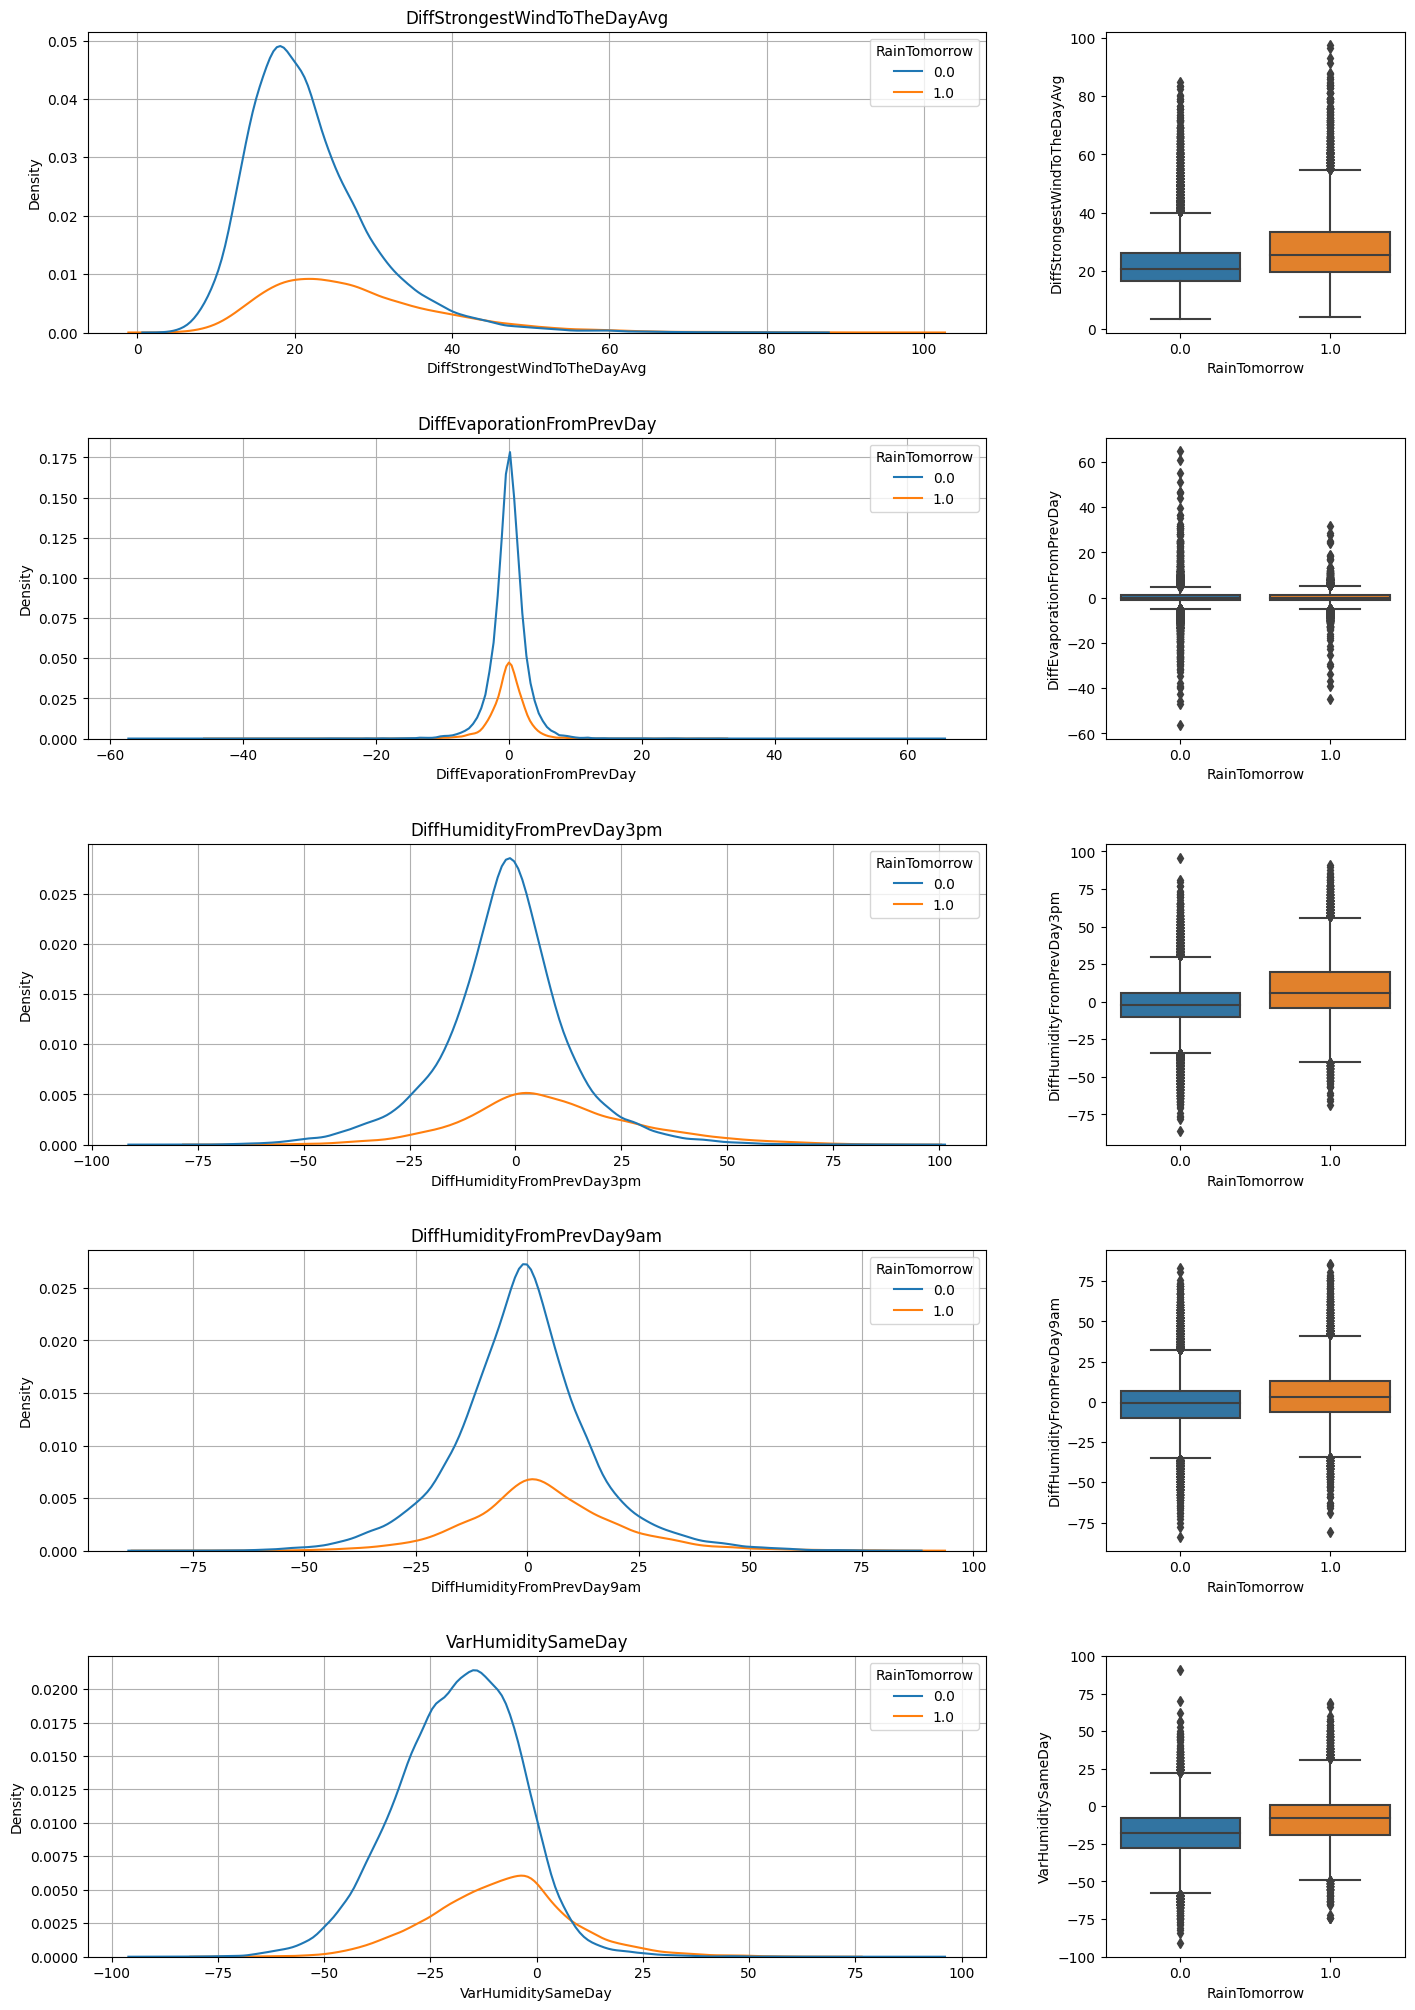

In [299]:

fig, axs = plt.subplots(nrows=len(new_cols), ncols=2, figsize=(17, len(new_cols) * 5),
                        gridspec_kw = {'hspace': 0.35, 'wspace': 0.2, 'width_ratios': [0.75, 0.25]})


for i, col in enumerate(new_cols):
    ax = axs[i, 0]
    sns.kdeplot(data=data[[col, 'RainTomorrow']], x=col, hue='RainTomorrow', ax=ax)
    ax.set_title(col)
    ax.grid(visible=True)

    ax = axs[i, 1]
    sns.boxplot(data=data[[col, target]], x=target, y=col, ax=ax)

plt.tight_layout()

In [300]:
corr_df = []
for col in new_cols:
    corr_df.append(pointbiserialr(data.RainTomorrow, data[col]).correlation)

pd.DataFrame(zip(new_cols, corr_df), columns=['Col', 'Corr'])

Col      Corr
0  DiffStrongestWindToTheDayAvg  0.257313
1    DiffEvaporationFromPrevDay -0.011499
2    DiffHumidityFromPrevDay3pm  0.266346
3    DiffHumidityFromPrevDay9am  0.122473
4            VarHumiditySameDay  0.270964

<p>The variation in humidity from one day to the other and in the same day and stronger wind speed seems to be slightly related with target

# Categorical Features

In [301]:
cate_var = data.select_dtypes('object').columns.to_list()
cate_var.remove('Location') #No point in including the city

<p> Maybe missing data can tell us something

In [302]:
data = data.apply(lambda col : col.fillna('Missing') if col.dtype == 'O' else col)

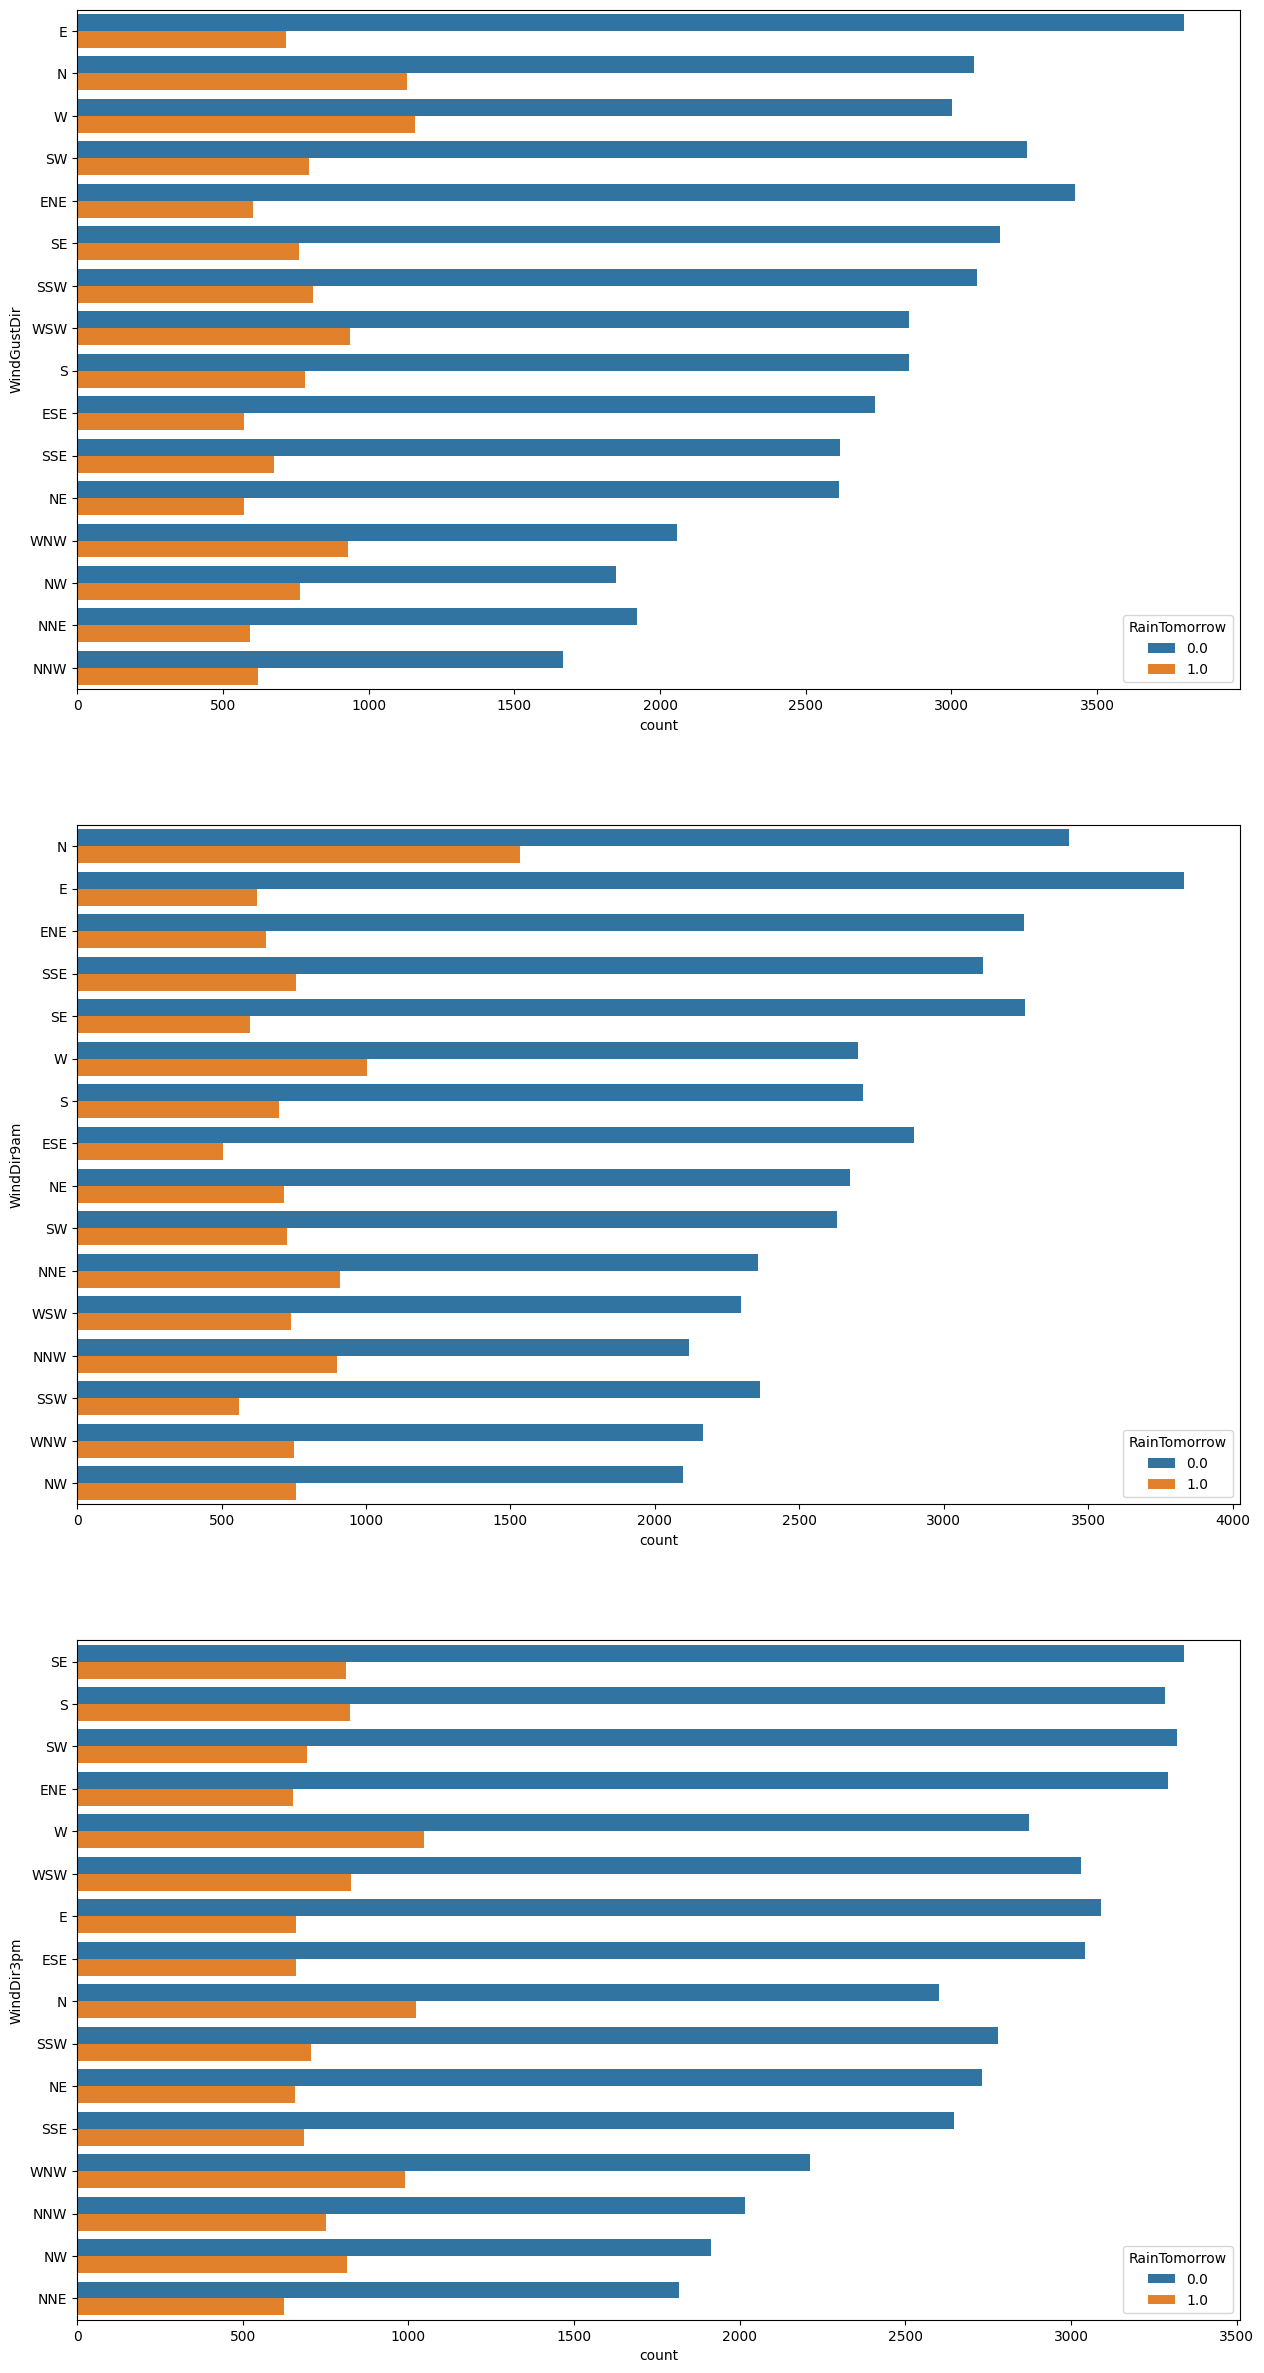

In [303]:
fig, ax = plt.subplots(nrows=len(cate_var), ncols = 1,  figsize=(15, 30))
ax = ax.flatten()

for i, col in enumerate(cate_var):
    sns.countplot(y = data[col], hue=data[target], ax=ax[i], order = data[col].value_counts().index)

### Considerations
<p> Only North wind at 9am seem to have any relation with target.
<p> Maybe the change of direction during the day may have some information

<Axes: xlabel='count', ylabel='WindDirChange'>

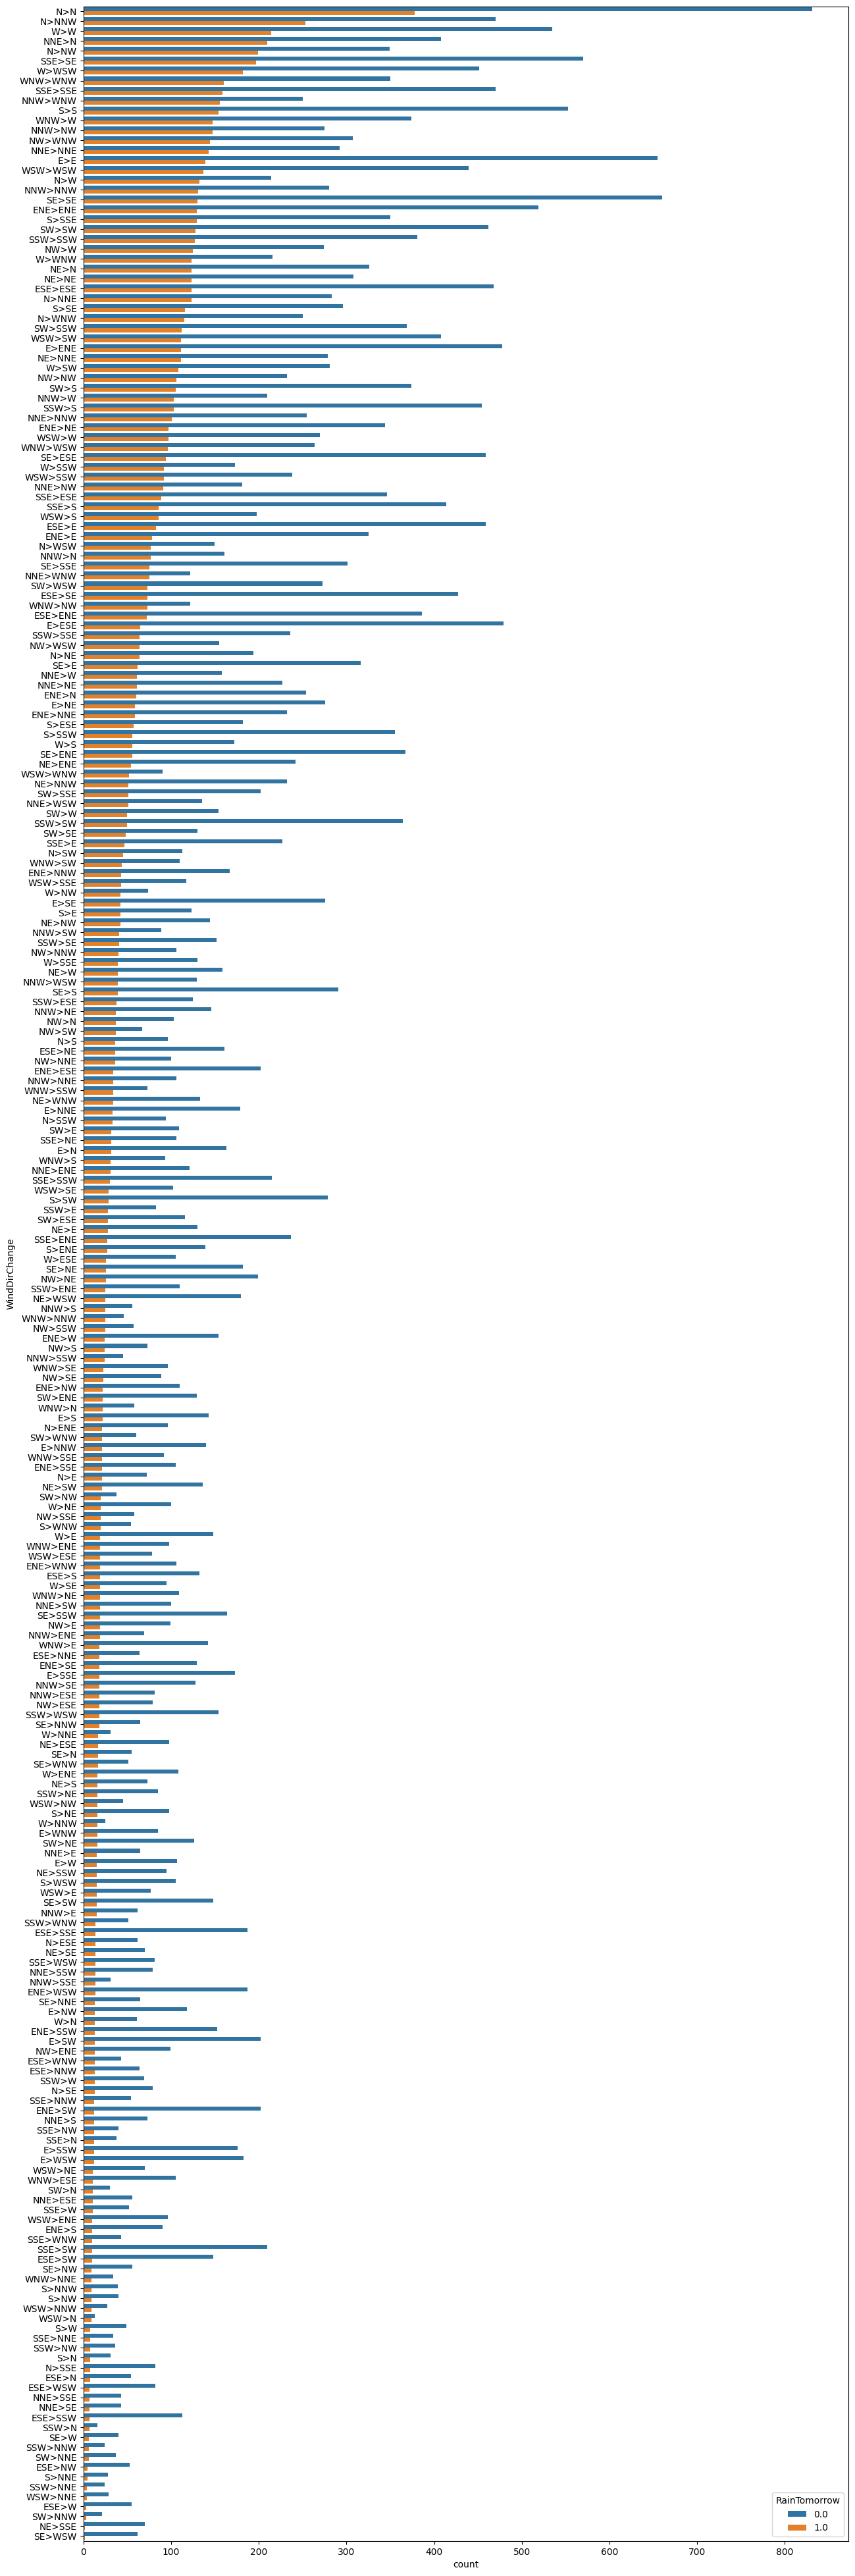

In [25]:
data['WindDirChange'] = data.WindDir9am + '>' + data.WindDir3pm
fig = plt.figure(figsize=(15, 50))
order = pd.crosstab(data['WindDirChange'], data[target]).sort_values(by=1, ascending=False).index
sns.countplot(y = data['WindDirChange'], hue=data[target], order = order)

In [39]:
associations = []
for col in data.select_dtypes(['object']).columns.tolist():
    cramer = association(pd.crosstab(data[col], data[target]), method='cramer')
    associations.append((col, cramer))
associations = pd.DataFrame(associations, columns=['Feature', 'Cramer'])
associations

Feature    Cramer
0       Location  0.170907
1    WindGustDir  0.114953
2     WindDir9am  0.132325
3     WindDir3pm  0.110343
4  WindDirChange  0.192534

<p>N>NNW seems to be a little bit related to the possibility of raining
<p>Overall, the categorical variables don't seem strongly related to the target

### Geographical location of cities

In [305]:
data.Location.unique()

array(['Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland', 'Sydney',
       'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Canberra', 'Sale',
       'MelbourneAirport', 'Melbourne', 'Mildura', 'Portland', 'Watsonia',
       'Brisbane', 'Cairns', 'Townsville', 'MountGambier', 'Nuriootpa',
       'Woomera', 'PerthAirport', 'Perth', 'Hobart', 'AliceSprings',
       'Darwin'], dtype=object)

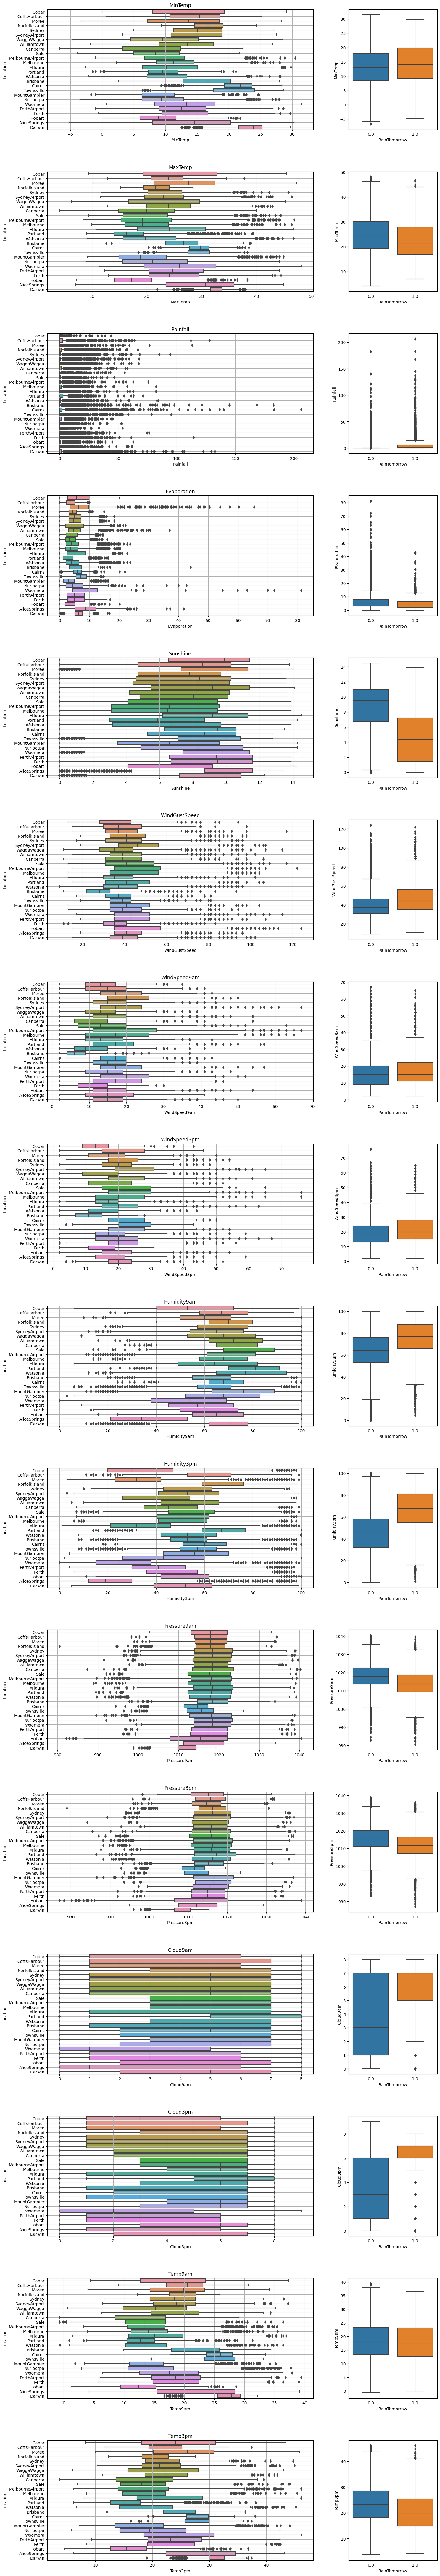

In [306]:
fig, axs = plt.subplots(nrows=len(cont_var), ncols=2, figsize=(17, len(cont_var) * 7),
                        gridspec_kw = {'hspace': 0.35, 'wspace': 0.2, 'width_ratios': [0.75, 0.25]})

for i, col in enumerate(cont_var):
    ax = axs[i, 0]
    sns.boxplot(y=data.Location, x=data[col], ax=ax)
    ax.set_title(col)
    ax.grid(visible=True)

    ax = axs[i, 1]
    sns.boxplot(data=data[[col, target]], x=target, y=col, ax=ax)

<p>The geographical location of cities implies that temperature and humidity and other rain indicators will have different behavior and min/max values. The variance from the geographical location mean should be more relevant than the variation from the median of the whole country.

In [41]:
medians_humidity_9am = {}
medians_humidity_3pm = {}
medians_min_temp = {}
medians_max_temp = {}
medians_temp_9am = {}
medians_temp_3pm = {}
medians_cloud_9am = {}
medians_cloud_3pm = {}

for location in data.Location.unique().tolist():
    medians_humidity_9am[location] = data[data.Location == location].Humidity9am.median()
    medians_humidity_3pm[location] = data[data.Location == location].Humidity3pm.median()
    medians_min_temp[location] = data[data.Location == location].MinTemp.median()
    medians_max_temp[location] = data[data.Location == location].MaxTemp.median()
    medians_temp_9am[location] = data[data.Location == location].Temp9am.median()
    medians_temp_3pm[location] = data[data.Location == location].Temp3pm.median()
    medians_cloud_9am[location] = data[data.Location == location].Cloud9am.median()
    medians_cloud_3pm[location] = data[data.Location == location].Cloud3pm.median()

In [42]:
data['VarFromLocalMinTemp'] = data.apply(
    lambda row : row.MinTemp - medians_min_temp[row.Location], axis=1)

data['VarFromLocalMaxTemp'] = data.apply(
    lambda row : row.MaxTemp - medians_max_temp[row.Location], axis=1)

data['VarFromLocalTemp9am'] = data.apply(
    lambda row : row.Temp9am - medians_temp_9am[row.Location], axis=1)

data['VarFromLocalTemp3pm'] = data.apply(
    lambda row : row.Temp3pm - medians_temp_3pm[row.Location], axis=1)

data['VarFromLocalCloud9am'] = data.apply(
    lambda row : row.Cloud9am - medians_cloud_9am[row.Location], axis=1)

data['VarFromLocalCloud3pm'] = data.apply(
    lambda row : row.Cloud3pm - medians_cloud_3pm[row.Location], axis=1)

data['VarFromLocalHumidity9am'] = data.apply(
    lambda row : row.Humidity9am - medians_humidity_9am[row.Location], axis=1)

data['VarFromLocalHumidity3pm'] = data.apply(
    lambda row : row.Humidity3pm - medians_humidity_3pm[row.Location], axis=1)

In [44]:
new_cols = ['VarFromLocalCloud3pm', 'VarFromLocalCloud9am', 'VarFromLocalHumidity3pm', 'VarFromLocalHumidity9am', 'VarFromLocalMinTemp', 'VarFromLocalMaxTemp', 'VarFromLocalTemp9am', 'VarFromLocalTemp3pm']

In [45]:
corr_df = []
for col in new_cols:
    corr_df.append(pointbiserialr(data.RainTomorrow, data[col]).correlation)

pd.DataFrame(zip(new_cols, corr_df), columns=['Col', 'Corr'])

Col      Corr
0     VarFromLocalCloud3pm  0.331379
1     VarFromLocalCloud9am  0.229470
2  VarFromLocalHumidity3pm  0.428256
3  VarFromLocalHumidity9am  0.233800
4      VarFromLocalMinTemp  0.099926
5      VarFromLocalMaxTemp -0.128337
6      VarFromLocalTemp9am -0.012414
7      VarFromLocalTemp3pm -0.172027

### Considerations about geographical locations
<p>Variation from the average Cloud level and Humidity of the city seems to be related to the target.